In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nb
import os
import math
from scipy.ndimage import zoom
import CMR_HFpEF_Analysis.data_simulation.transformation as transform
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.Defaults as Defaults
import CMR_HFpEF_Analysis.Image_utils as util
import CMR_HFpEF_Analysis.sunny_brooks.functions_for_LAX as ff_LAX

2023-02-22 21:40:49.222570: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# the line with ############: you can find the numbers from LAX_comparison_preparation.xlsx and LAX_assessment_sunny_brooks.xlsx

load case

(128, 128, 70)


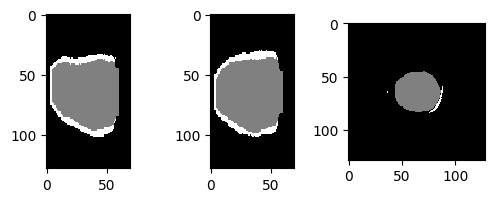

In [89]:
# load case
main_path  = os.path.join('/mnt/mount_zc_NAS/HFpEF/predict/Sunny_Brooks/Iteration_C/round_1/images')
case_path = os.path.join(main_path, 'SC-HF-NI-36/tf2/pred_img_HR_final.nii.gz')
case = nb.load(case_path)
spacing = [1.3672, 1.3672, 1.6]
affine = case.affine
img = case.get_fdata()
img = np.round(img); img = img.astype(int)

# zoom to have the same dimension
img = zoom(img, [1,1,spacing[-1]/1.3672], order = 0)

print(img.shape)

plt.figure(figsize = (6,2))
plt.subplot(131); plt.imshow(img[64, ...], 'gray')
plt.subplot(132); plt.imshow(img[:,64, :], 'gray')
plt.subplot(133); plt.imshow(img[:,:,57], 'gray')

find LV long axis

In [79]:
original_apex_slice = 5   ############
original_base_slice = 53  ############
original_apex_mid, original_base_mid, L_list, x_list, y_list, base_point_list = ff_LAX.long_axis(img, original_apex_slice, original_base_slice, incre_unit = 3)
print(len(L_list))
if len(L_list) >= 15:
    original_apex_mid, original_base_mid, L_list, x_list, y_list, base_point_list = ff_LAX.long_axis(img, original_apex_slice, original_base_slice, incre_unit = 4)   
ii = 12   ############
L = L_list[ii]
x = x_list[ii]
y = y_list[ii]

img_new = ff_LAX.resample_img(img, original_apex_mid, L, x, y)

25


In [124]:
# find apex slice and basal slice
original_apex_slice = 5
original_base_slice = 53

# now find apex mid point
original_apex_mid = util.center_of_mass(img[:,:,original_apex_slice],0 ,large = True)
original_apex_mid = np.round(np.asarray([original_apex_mid[0], original_apex_mid[1], original_apex_slice])).astype(int)
original_base_mid = util.center_of_mass(img[:,:,original_base_slice],0, large = True)
original_base_mid = np.round(np.asarray([original_base_mid[0], original_base_mid[1], original_base_slice])).astype(int)
print(original_base_mid, original_apex_mid)

# long-axis
L = original_base_mid - original_apex_mid
L = ff.normalize(L)

L = np.asarray([0,0,1])
# find two perpendicular axes to L (these should be the new x and y)
a = [0,-1,0]
x = ff.normalize(np.cross(L, a))
y = ff.normalize(np.cross(L, x))
# L = np.round(L,4); x = np.round(x,4); y = np.round(y,4)

print(L,x,y)

# let's resample the volume
# first, we need a list of centers along the Long-axis
# start from apex mid:
centers  = []
count_a = (original_apex_mid[-1] - 0) // L[-1]
count_b = (img.shape[-1] - original_apex_mid[-1]) // L[-1]

for i in range(int(-count_a),int(count_b)+1):
    c = original_apex_mid + L * i
    centers.append(c)
# centers = centers[:img.shape[-1]]
print(len(centers))

# define interpolation
interpolation = ff.define_interpolation(img)

# reslice
img_new = np.zeros((img.shape[0],img.shape[1], len(centers)))
for i in range(0, len(centers)):
    img_new[:,:,i] = ff.reslice_mpr(np.zeros([img.shape[0], img.shape[1]]), centers[i],x,y,1,1,interpolation)

[62 57 53] [52 48  5]
[0 0 1] [1. 0. 0.] [0. 1. 0.]
71


load LAX

(1.3656387, 1.3656387, 7.0)
gt y: 22 93 (72,)
gt x:  31 98 (68,)


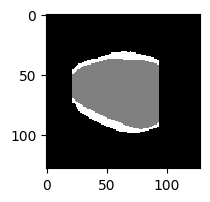

In [85]:
# load endo segmentation first
filepath = '/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks/LAX'
endo_file = os.path.join(filepath, 'contours/SC-HF-NI-36/4CH_2_endo.nii.gz')
endo = nb.load(endo_file).get_fdata()
print(nb.load(endo_file).header.get_zooms())
# print(endo.shape, np.unique(endo))

# load epi segmentation
epi_file = os.path.join(filepath, 'contours/SC-HF-NI-36/4CH_2_epi.nii.gz')
epi = nb.load(epi_file).get_fdata()
# print(epi.shape, np.unique(epi))

gt = np.copy(epi)
gt[epi==1] = 2
gt[endo==1] = 1


# find out which slice has segmentation
S = [i for i in range(0,endo.shape[-1]) if np.sum(endo[:,:,i]) > 0][0]
gt = gt[:,:, S]

# move to center
gt = util.move_heart_center_to_image_center(gt)

# flip 
gt = np.flip(gt,1)

# dimension
gt = util.crop_or_pad(gt,[128,128])

# y axis crop
gt[:,94:] = 0  ############
gt[:,:22] = 0  ############
gt_slices = np.asarray([ii for ii in range(0,gt.shape[-1]) if np.sum(gt[:,ii]) > 0])
print('gt y:' ,gt_slices[0], gt_slices[-1], gt_slices.shape)

# x axis zoom
gt_slices_x = np.asarray([ii for ii in range(0,gt.shape[0]) if np.sum(gt[ii,:]) > 0])
print('gt x: ',gt_slices_x[0], gt_slices_x[-1], gt_slices_x.shape)

# gt_copy = np.copy(gt)
# gt_copy = zoom(gt_copy, [1.15,1] ,order = 0)  ############
# gt_copy_slices = np.asarray([ii for ii in range(0,gt_copy.shape[0]) if np.sum(gt_copy[ii,:]) > 0])
# gt = np.zeros(gt.shape)
# gt[gt_copy_slices[0]: gt_copy_slices[-1]+1, :] = gt_copy[gt_copy_slices[0]: gt_copy_slices[-1]+1, :]
# gt = util.move_heart_center_to_image_center(gt)

# # # x axis crop
# print('gt new x: ',np.asarray([ii for ii in range(0,gt.shape[0]) if np.sum(gt[ii,:]) > 0])[0], np.asarray([ii for ii in range(0,gt.shape[0]) if np.sum(gt[ii,:]) > 0])[-1])
# gt[:36, :] = 0  ############


plt.figure(figsize = (2,2))
plt.imshow(gt, 'gray')

# nb.save(nb.Nifti1Image(gt,affine = nb.load(epi_file).affine, header = nb.load(epi_file).header), os.path.join(os.path.dirname(epi_file), 'gt_processed.nii.gz'))

compare

[58 65  7]


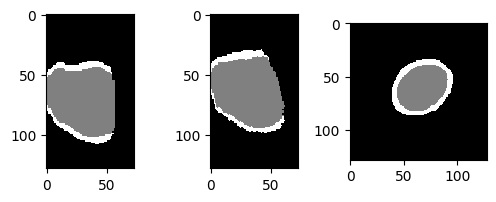

In [81]:
# find new long axis
new_apex_slice = 7  ############
new_apex_mid = util.center_of_mass(img_new[:,:,new_apex_slice],0 ,large = True)
new_apex_mid = np.round(np.asarray([new_apex_mid[0], new_apex_mid[1], new_apex_slice])).astype(int)
print(new_apex_mid)
 
# z-axis across new_apex_mid is the new long axis

plt.figure(figsize = (6,2))
plt.subplot(131); plt.imshow(img_new[new_apex_mid[0], ...], 'gray')
plt.subplot(132); plt.imshow(img_new[:,new_apex_mid[1], :], 'gray')
plt.subplot(133); plt.imshow(img_new[:,:,13], 'gray') 

apex:  3 -4
original slice number x:  32 100 (69,)
original slice number y:  (53,)
best mean DICE:  3 -4 -20 3 0.962165395543592 0.6779431664411367 0.8200542809923643
best mean HD:  3 -4 -20 3 4.3228335614501745 6.113409850484425 5.2181217059673


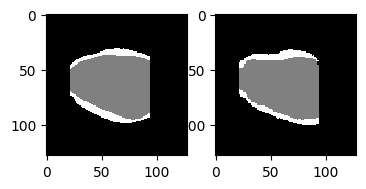

In [88]:
# gt = nb.load(os.path.join(os.path.dirname(epi_file), 'gt_processed.nii.gz')).get_fdata(); gt = np.round(gt).astype(int)
# gt_slices = np.asarray([ii for ii in range(0,gt.shape[-1]) if np.sum(gt[:,ii]) > 0])

max_lv_dice = 0; max_myo_dice = 0; max_mean_dice = 0
min_lv_HD = 1000; min_myo_HD = 1000; min_mean_HD = 1000
optim_lv_dice = [0,0,0,0]; optim_myo_dice = [0,0,0,0]; optim_mean_dice = [0,0,0,0]
optim_lv_HD = [0,0,0,0]; optim_myo_HD = [0,0,0,0]; optim_mean_HD = [0,0,0,0]

pred_pre_crop =  2 ########

for apex_x in range(3,4): ############
    for apex_y in range(-4,-3): ############
        print('apex: ', apex_x, apex_y)
        for r in range(-20,-10,10): ############
            apex_m = new_apex_mid - np.asarray([apex_x, apex_y, 0])
            translation,rotation,scale,M = transform.generate_transform_matrix([0,0,0],[0,0,r / 180 * np.pi],[1,1,1],img_new.shape)
            M = transform.transform_full_matrix_offset_heart(M, np.array([apex_m[0], apex_m[1], img_new.shape[-1]//2]))
            img_t = transform.apply_affine_transform(img_new, M, order = 0)

            pred = img_t[apex_m[0],:,:]
            pred = util.crop_or_pad(pred,[128,128])

            # move to center
            pred = util.move_heart_center_to_image_center(pred)

            # crop base
            heart_slice = np.asarray([ii for ii in range(0,pred.shape[1]) if np.sum(pred[:,ii]) > 0])

            for crop_base in range(3,4): ############
                pred[:,(heart_slice[-1] - pred_pre_crop - crop_base):] = 0

                # make the slice number equal to gt
                pred_slices = np.asarray([ii for ii in range(0,pred.shape[0]) if np.sum(pred[ii,:]) > 0])
                print('original slice number x: ',pred_slices[0],pred_slices[-1], pred_slices.shape)

                pred_slices = np.asarray([ii for ii in range(0,pred.shape[-1]) if np.sum(pred[:,ii]) > 0])
                print('original slice number y: ',pred_slices.shape)
                pred_copy = np.copy(pred)
                pred_copy = zoom(pred_copy, [1, gt_slices.shape[0] / pred_slices.shape[0]], order = 0)
                pred_copy_slices = np.asarray([ii for ii in range(0,pred_copy.shape[-1]) if np.sum(pred_copy[:,ii]) > 0])
                pred = np.zeros(pred.shape)
                pred[:, pred_copy_slices[0]: pred_copy_slices[-1]+1] = pred_copy[:, pred_copy_slices[0]: pred_copy_slices[-1]+1]
                pred_slices = np.asarray([ii for ii in range(0,pred.shape[-1]) if np.sum(pred[:,ii]) > 0])
                # print('new slice number: ',pred_slices.shape)

                # make the base slice overlap
                move = [0, gt_slices[-1] - pred_slices[-1]]
                pred = util.move_3Dimage(pred, move)

  

                plt.figure(figsize = (4,2))
                plt.subplot(121); plt.imshow(gt, 'gray')
                plt.subplot(122); plt.imshow(pred, 'gray')
                

                ##### dice
                # pred_lv_dice, ds, _ = util.Dice_optim(pred, gt, [1], d = 5, threeDimage=False)
                # pred_myo_dice, ds, _ = util.Dice_optim(pred, gt, [2], d = 5, threeDimage=False)
                
                # if pred_lv_dice > max_lv_dice:
                #     optim_lv_dice = [apex_x, apex_y, r,crop_base]
                #     max_lv_dice = pred_lv_dice
                #     print('best lv DICE: ',apex_x, apex_y, r, crop_base, pred_lv_dice)

                # if pred_myo_dice > max_myo_dice:
                #     optim_myo_dice = [apex_x, apex_y, r,crop_base]
                #     max_myo_dice = pred_myo_dice
                #     print('best myo DICE: ',apex_x, apex_y, r, crop_base, pred_myo_dice)
                

                pred_mean_dice, ds, pred_for_dice = util.Dice_optim(pred, gt, [1,2], d = 5, threeDimage=False)
                if pred_mean_dice > max_mean_dice:
                    max_mean_dice = pred_mean_dice
                    optim_mean_dice = [apex_x, apex_y, r, crop_base]
                    pred_mean_lv_dice = ff.np_categorical_dice(pred_for_dice, gt, 1)
                    pred_mean_myo_dice = ff.np_categorical_dice(pred_for_dice, gt, 2)
                    print('best mean DICE: ',apex_x, apex_y, r, crop_base, pred_mean_lv_dice, pred_mean_myo_dice, pred_mean_dice)

                ##### HD
                # pred_lv_HD, _, _= util.HD_optim(pred, gt,  min = False, k_list = [1], d = 5, pixel_size = 1.367, threeDimage = False)
                # pred_myo_HD, _, _= util.HD_optim(pred, gt,  min = False, k_list = [2], d = 5, pixel_size = 1.367, threeDimage = False) 
                
                # if pred_lv_HD < min_lv_HD:
                #     optim_lv_HD = [apex_x, apex_y, r,crop_base]
                #     min_lv_HD = pred_lv_HD
                #     print('best lv HD: ',apex_x, apex_y, r, crop_base, pred_lv_HD)

                # if pred_myo_HD < min_myo_HD:
                #     optim_myo_HD = [apex_x, apex_y, r,crop_base]
                #     min_myo_HD = pred_myo_HD
                #     print('best myo HD: ',apex_x, apex_y, r, crop_base, pred_myo_HD)

                pred_mean_HD, ds, pred_for_HD = util.HD_optim(pred, gt, min = False, k_list = [1,2], d = 5, pixel_size = 1.367, threeDimage=False)
                if pred_mean_HD < min_mean_HD:
                    optim_mean_HD = [apex_x, apex_y, r, crop_base]
                    min_mean_HD = pred_mean_HD
                    gt_lv_pixels = np.asarray(ff.count_pixel(gt,1)[1]); gt_myo_pixels = np.asarray(ff.count_pixel(gt,2)[1])
                    pred_lv_pixels = np.asarray(ff.count_pixel(pred_for_HD,1)[1]); pred_myo_pixels = np.asarray(ff.count_pixel(pred_for_HD,2)[1])

                    pred_mean_lv_HD = ff.HD( pred_lv_pixels, gt_lv_pixels, pixel_size = 1.367, min = False)
                    pred_mean_myo_HD = ff.HD( pred_myo_pixels, gt_myo_pixels,pixel_size = 1.367, min = False)
                    
                    print('best mean HD: ',apex_x, apex_y, r, crop_base, pred_mean_lv_HD, pred_mean_myo_HD, pred_mean_HD)